# **Cat vs Dog Image Classificastion**

### **Listing 8.6 Copying images to training, validation, and test directories**

In [1]:
import os, shutil, pathlib

In [2]:
original_dir = pathlib.Path("train") # Path to the directory where the original dataset was uncompressed

In [3]:
new_base_dir = pathlib.Path("cats_vs_dogs_small") # Directory where we will store our smaller dataset

Utility function to copy cat (and dog) images from index start_index to index end_index to the subdirectory new_base_dir/{subset_name}/cat (and /dog). The
"subset_name" will be either "train", "validation", or "test".

In [4]:
def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname, dst=dir / fname)

In [5]:
make_subset("train", start_index=0, end_index=9000)  
make_subset("validation", start_index=9000, end_index=11000)
make_subset("test", start_index=11000, end_index=12499)

We now have 2,000 training images, 1,000 validation images, and 2,000 test images.
Each split contains the same number of samples from each class: this is a balanced
binary-classification problem, which means classification accuracy will be an appropriate measure of success. 

# **Building the model**

### **Listing 8.7 Instantiating a small convnet for dogs vs. cats classification**

In [6]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))

x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

### **Listing 8.8 Configuring the model for training**

In [7]:
model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

# **Data preprocessing**

Calling image_dataset_from_directory(directory) will first list the subdirectories of directory and assume each one contains images from one of our classes. It will
then index the image files in each subdirectory. Finally, it will create and return a
tf.data.Dataset object configured to read these files, shuffle them, decode them to
tensors, resize them to a shared size, and pack them into batches.

### **Listing 8.9 Using image_dataset_from_directory to read images**

In [8]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size = (180, 180),
    batch_size = 32,)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size = (180, 180),
    batch_size = 32,)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size = (180, 180),
    batch_size = 32,)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


Let’s look at the output of one of these Dataset objects: it yields batches of 180 × 180
RGB images (shape (32, 180, 180, 3)) and integer labels (shape (32,)). There are
32 samples in each batch (the batch size).

### **Listing 8.10 Displaying the shapes of the data and labels yielded by the Dataset**

In [9]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


Let’s fit the model on our dataset. We’ll use the validation_data argument in fit()
to monitor validation metrics on a separate Dataset object.

Note that we’ll also use a ModelCheckpoint callback to save the model after each
epoch. We’ll configure it with the path specifying where to save the file, as well as the
arguments save_best_only=True and monitor="val_loss": they tell the callback to
only save a new file (overwriting any previous one) when the current value of the
val_loss metric is lower than at any previous time during training. This guarantees
that your saved file will always contain the state of the model corresponding to its bestperforming training epoch, in terms of its performance on the validation data. As a
result, we won’t have to retrain a new model for a lower number of epochs if we start
overfitting: we can just reload our saved file.

### **Listing 8.11 Fitting the model using a Dataset**

In [10]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss",)
]

In [11]:
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 7s 71ms/step - loss: 0.7556 - accuracy: 0.4880 - val_loss: 0.6921 - val_accuracy: 0.5400
Epoch 2/30
63/63 [==============================] - 3s 49ms/step - loss: 0.6939 - accuracy: 0.5205 - val_loss: 0.6893 - val_accuracy: 0.5700
Epoch 3/30
63/63 [==============================] - 3s 48ms/step - loss: 0.6838 - accuracy: 0.5645 - val_loss: 0.6904 - val_accuracy: 0.5340
Epoch 4/30
63/63 [==============================] - 3s 49ms/step - loss: 0.6696 - accuracy: 0.6115 - val_loss: 0.6207 - val_accuracy: 0.6740
Epoch 5/30
63/63 [==============================] - 3s 49ms/step - loss: 0.6056 - accuracy: 0.6795 - val_loss: 0.7772 - val_accuracy: 0.6050
Epoch 6/30
63/63 [==============================] - 3s 49ms/step - loss: 0.5915 - accuracy: 0.7115 - val_loss: 0.5744 - val_accuracy: 0.7060
Epoch 7/30
63/63 [==============================] - 3s 47ms/step - loss: 0.5257 - accuracy: 0.7465 - val_loss: 0.6558 - val_accuracy: 0.6680
Epoch 8/30
63

Let’s plot the loss and accuracy of the model over the training and validation data
during training

### **Listing 8.12 Displaying curves of loss and accuracy during training**

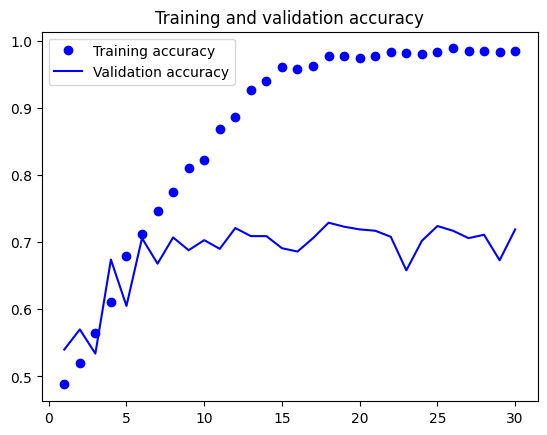

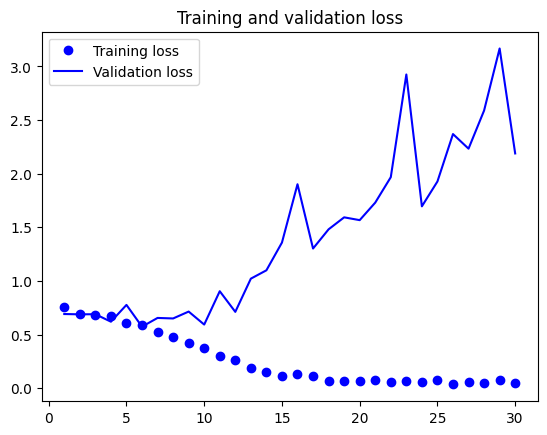

In [12]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

These plots are characteristic of overfitting. The training accuracy increases linearly
over time, until it reaches nearly 100%, whereas the validation accuracy peaks at 75%.
The validation loss reaches its minimum after only ten epochs and then stalls, whereas
the training loss keeps decreasing linearly as training proceeds.

 Let’s check the test accuracy. We’ll reload the model from its saved file to evaluate
it as it was before it started overfitting

### **Listing 8.13 Evaluating the model on the test set**

In [13]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accurracy: {test_acc:.3f}")

63/63 [==============================] - 2s 27ms/step - loss: 0.5912 - accuracy: 0.6950
Test accurracy: 0.695


We get a test accuracy of 69.50%. (Due to the randomness of neural network initializations, you may get numbers within one percentage point of that.)


Because we have relatively few training samples (2,000), overfitting will be our
number one concern. You already know about a number of techniques that can help
mitigate overfitting, such as dropout and weight decay (L2 regularization). We’re now
going to work with a new one, specific to computer vision and used almost universally
when processing images with deep learning models: data augmentation. 

# **Using data augmentation**

Overfitting is caused by having too few samples to learn from, rendering you unable
to train a model that can generalize to new data. Given infinite data, your model
would be exposed to every possible aspect of the data distribution at hand: you would
never overfit. Data augmentation takes the approach of generating more training data
from existing training samples by augmenting the samples via a number of random
transformations that yield believable-looking images. The goal is that, at training time,
your model will never see the exact same picture twice. This helps expose the model
to more aspects of the data so it can generalize better.

In Keras, this can be done by adding a number of data augmentation layers at the
start of your model. Let’s get started with an example: the following Sequential model
chains several random image transformations. In our model, we’d include it right
before the Rescaling layer.

### **Listing 8.14 Define a data augmentation stage to add to an image model**

In [14]:
data_agumentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2)
    ]
)

These are just a few of the layers available (for more, see the Keras documentation).

Let’s quickly go over this code:
 - RandomFlip("horizontal")—Applies horizontal flipping to a random 50% of the images that go through it

 - RandomRotation(0.1)—Rotates the input images by a random value in the range [–10%, +10%] (these are fractions of a full circle—in degrees, the range would be [–36 degrees, +36 degrees])

 - RandomZoom(0.2)—Zooms in or out of the image by a random factor in the range [-20%, +20%]

Let’s look at the augmented images

### **Listing 8.15 Displaying some randomly augmented training images**

In [15]:
# If the warnings clutter your notebook output, you can suppress them like this:
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

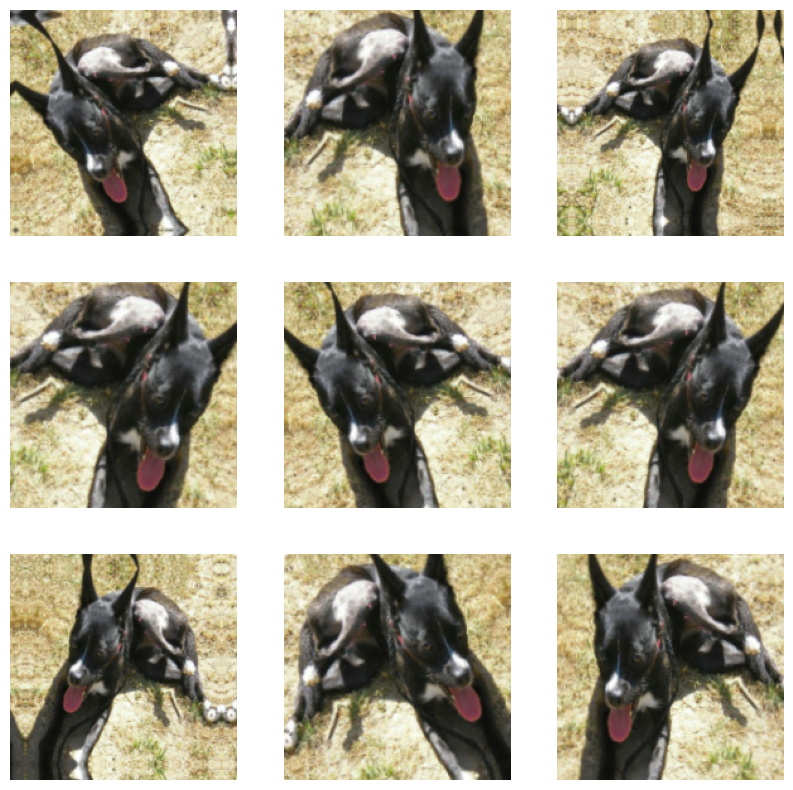

In [16]:
plt.figure(figsize=(10,10))
for images, _ in train_dataset.take(1):  # We can use take(N) to only sampleN batches from the dataset. This is equivalent to inserting a break in the loop after the Nth batch.
    for i in range(9):
        augmented_images = data_agumentation(images) # Apply theaugmentation stage to the batch of images.
        ax = plt.subplot(3,3,i+1)
        plt.imshow(augmented_images[0].numpy().astype("uint8")) # Display the first image in the output batch. For each of the nine iterations, this is a different augmentation of the same image.
        plt.axis("off")

If we train a new model using this data-augmentation configuration, the model will never see the same input twice. But the inputs it sees are still heavily intercorrelated because they come from a small number of original images—we can’t produce new information; we can only remix existing information. As such, this may not be enough to completely get rid of overfitting. To further fight overfitting, we’ll also add a Dropout layer to our model right before the densely connected classifier.

One last thing you should know about random image augmentation layers: just
like Dropout, they’re inactive during inference (when we call predict() or evaluate()).
During evaluation, our model will behave just the same as when it did not include
data augmentation and dropout.

### **Listing 8.16 Defining a new convnet that includes image augmentation and dropout**

In [17]:
inputs = keras.Input(shape=(180,180,3))
x = data_agumentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

### **Listing 8.17 Training the regularized convnet**

In [18]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss",)
]

In [19]:
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
63/63 [==============================] - 12s 160ms/step - loss: 0.8348 - accuracy: 0.5055 - val_loss: 0.7651 - val_accuracy: 0.5000
Epoch 2/100
63/63 [==============================] - 10s 151ms/step - loss: 0.6956 - accuracy: 0.5105 - val_loss: 0.6896 - val_accuracy: 0.5120
Epoch 3/100
63/63 [==============================] - 9s 149ms/step - loss: 0.6926 - accuracy: 0.5260 - val_loss: 0.6980 - val_accuracy: 0.5040
Epoch 4/100
63/63 [==============================] - 9s 150ms/step - loss: 0.7186 - accuracy: 0.5680 - val_loss: 0.6661 - val_accuracy: 0.6090
Epoch 5/100
63/63 [==============================] - 10s 152ms/step - loss: 0.6709 - accuracy: 0.5925 - val_loss: 0.6412 - val_accuracy: 0.6250
Epoch 6/100
63/63 [==============================] - 10s 153ms/step - loss: 0.6565 - accuracy: 0.6355 - val_loss: 0.6291 - val_accuracy: 0.6330
Epoch 7/100
63/63 [==============================] - 9s 150ms/step - loss: 0.6422 - accuracy: 0.6640 - val_loss: 0.6158 - val_accuracy: 0.

### **Listing 8.18 Evaluating the model on the test set**

In [20]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 1s 18ms/step - loss: 1.0753 - accuracy: 0.8290
Test accuracy: 0.829


# **Leveraging a pretrained model**

## **Feature extraction with a pretrained model**

### **Listing 8.19 Instantiating the VGG16 convolutional base**

In [21]:
conv_base = keras.applications.vgg16.VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(180, 180, 3))

In [22]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

### **Listing 8.20 Extracting the VGG16 features and corresponding labels**

In [23]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)    

In [24]:
train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 17ms/step


In [25]:
train_features.shape

(2000, 5, 5, 512)

### **Listing 8.21 Defining and training the densely connected classifier**

In [26]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)  # Note the use of the Flatten layer beforre passing the features to a Dense layer.
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

In [27]:
model.compile(loss="binary_crossentropy",
optimizer="rmsprop",
metrics=["accuracy"])

In [28]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction.keras",
        save_best_only=True,
        monitor="val_loss")
]

In [29]:
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 1s 10ms/step - loss: 12.7504 - accuracy: 0.9200 - val_loss: 5.7109 - val_accuracy: 0.9660
Epoch 2/20
63/63 [==============================] - 0s 6ms/step - loss: 2.3554 - accuracy: 0.9835 - val_loss: 4.4121 - val_accuracy: 0.9700
Epoch 3/20
63/63 [==============================] - 0s 6ms/step - loss: 1.8768 - accuracy: 0.9855 - val_loss: 5.0123 - val_accuracy: 0.9700
Epoch 4/20
63/63 [==============================] - 0s 6ms/step - loss: 0.9390 - accuracy: 0.9905 - val_loss: 5.1504 - val_accuracy: 0.9690
Epoch 5/20
63/63 [==============================] - 0s 6ms/step - loss: 1.5138 - accuracy: 0.9870 - val_loss: 5.9625 - val_accuracy: 0.9670
Epoch 6/20
63/63 [==============================] - 0s 6ms/step - loss: 1.7402 - accuracy: 0.9895 - val_loss: 4.7165 - val_accuracy: 0.9720
Epoch 7/20
63/63 [==============================] - 0s 6ms/step - loss: 0.6559 - accuracy: 0.9940 - val_loss: 4.3858 - val_accuracy: 0.9740
Epoch 8/20
63/63 [

### **Listing 8.22 Plotting the results**

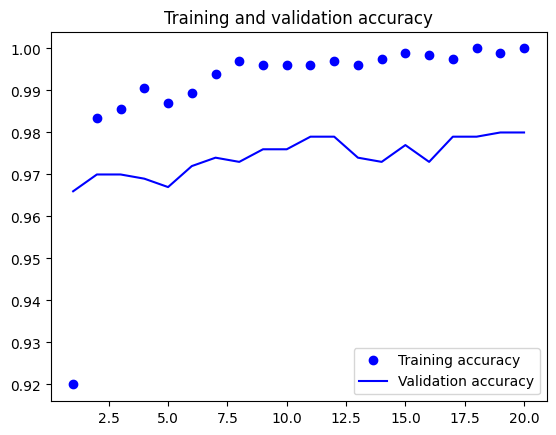

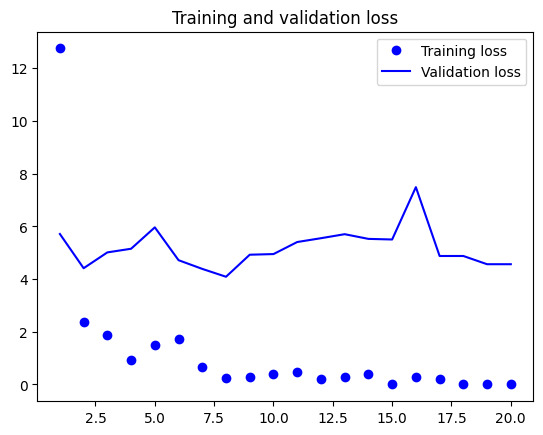

In [30]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In Keras, we freeze a layer or model by setting its trainable attribute to False.

### **Listing 8.23 Instantiating and freezing the VGG16 convolutional base**

In [31]:
conv_base = keras.applications.vgg16.VGG16(
    weights='imagenet',
    include_top=False)
conv_base.trainable = False

Setting trainable to False empties the list of trainable weights of the layer or model.

### **Listing 8.24 Printing the list of trainable weights before and after freezing**

In [32]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [33]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


### **Listing 8.25 Adding a data augmentation stage and a classifier to the convolutional base**

In [36]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180,180,3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              metrics=["accuracy"])

In [37]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
    filepath="feature_extraction_with_data_augmentation.keras",
    save_best_only=True,
    monitor="val_loss")
]

In [38]:
history = model.fit(
train_dataset,
epochs=50,
validation_data=validation_dataset,
callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 17s 229ms/step - loss: 16.2042 - accuracy: 0.8995 - val_loss: 9.0383 - val_accuracy: 0.9500
Epoch 2/50
63/63 [==============================] - 14s 229ms/step - loss: 7.4169 - accuracy: 0.9410 - val_loss: 4.9697 - val_accuracy: 0.9680
Epoch 3/50
63/63 [==============================] - 14s 228ms/step - loss: 6.8340 - accuracy: 0.9500 - val_loss: 4.2406 - val_accuracy: 0.9720
Epoch 4/50
63/63 [==============================] - 13s 207ms/step - loss: 3.6238 - accuracy: 0.9720 - val_loss: 3.3362 - val_accuracy: 0.9720
Epoch 5/50
63/63 [==============================] - 12s 189ms/step - loss: 2.8785 - accuracy: 0.9730 - val_loss: 3.9357 - val_accuracy: 0.9730
Epoch 6/50
63/63 [==============================] - 12s 188ms/step - loss: 4.3209 - accuracy: 0.9730 - val_loss: 6.8441 - val_accuracy: 0.9690
Epoch 7/50
63/63 [==============================] - 12s 188ms/step - loss: 2.9332 - accuracy: 0.9750 - val_loss: 6.5785 - val_accuracy: 0.968

Plotting the results

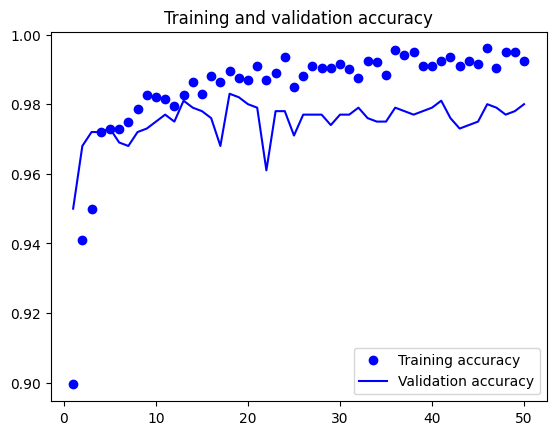

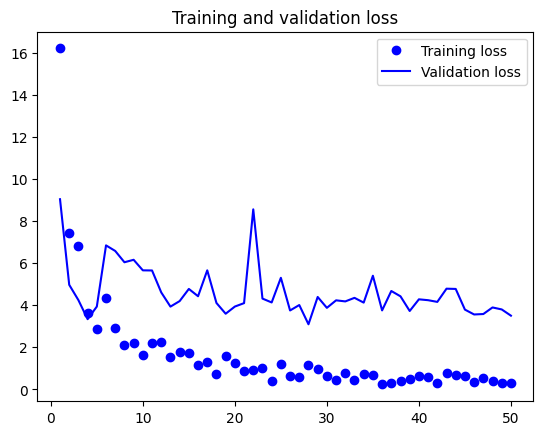

In [39]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### **Listing 8.26 Evaluating the model on the test set**

In [40]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 5s 77ms/step - loss: 3.8656 - accuracy: 0.9775
Test accuracy: 0.978


# **Fine-tuning a pretrained model**

### **Listing 8.27 Freezing all layers until the fourth from the last**

In [41]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

### **Listing 8.28 Fine-tuning the model**

In [42]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

In [43]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
    filepath="fine_tuning.keras",
    save_best_only=True,
    monitor="val_loss")
]

In [44]:
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 17s 242ms/step - loss: 2.9942 - accuracy: 0.9705 - val_loss: 2.5226 - val_accuracy: 0.9790
Epoch 2/30
63/63 [==============================] - 15s 236ms/step - loss: 1.6868 - accuracy: 0.9805 - val_loss: 2.7658 - val_accuracy: 0.9800
Epoch 3/30
63/63 [==============================] - 15s 236ms/step - loss: 1.5007 - accuracy: 0.9755 - val_loss: 2.6265 - val_accuracy: 0.9800
Epoch 4/30
63/63 [==============================] - 15s 237ms/step - loss: 1.1500 - accuracy: 0.9820 - val_loss: 2.4686 - val_accuracy: 0.9800
Epoch 5/30
63/63 [==============================] - 15s 236ms/step - loss: 0.8995 - accuracy: 0.9845 - val_loss: 2.8032 - val_accuracy: 0.9790
Epoch 6/30
63/63 [==============================] - 15s 236ms/step - loss: 0.6719 - accuracy: 0.9845 - val_loss: 2.6076 - val_accuracy: 0.9780
Epoch 7/30
63/63 [==============================] - 15s 237ms/step - loss: 0.4197 - accuracy: 0.9870 - val_loss: 3.3902 - val_accuracy: 0.9770

Plotting the results

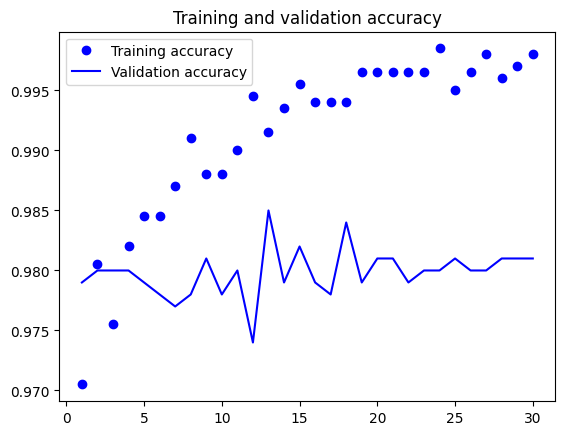

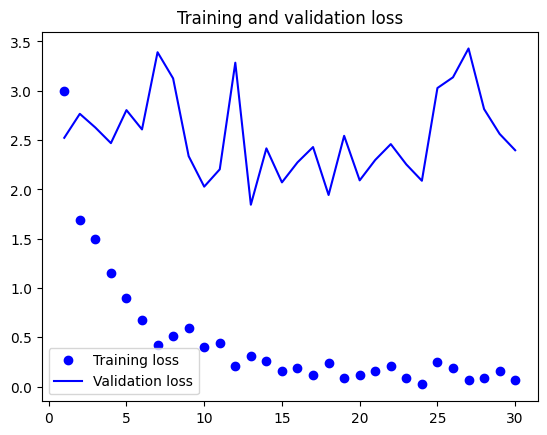

In [45]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

We can finally evaluate this model on the test data:

In [46]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 5s 77ms/step - loss: 2.3449 - accuracy: 0.9755
Test accuracy: 0.975
